# Example Usage

In [173]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi
import operator
import tensorflow as tf


# Loading the trained model
model = tf.keras.models.load_model("model/model.keras")


c:\Users\jaide\anaconda3\envs\mnist\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [175]:
# Display the above process in a step by step manner, without calling the above defined functions

img_path = "sudoku1.jpg"

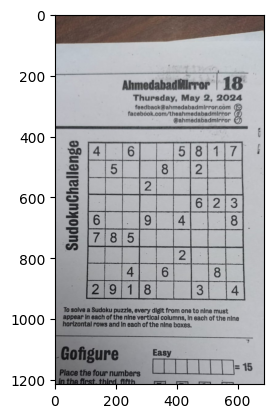

In [176]:
# Read the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img)

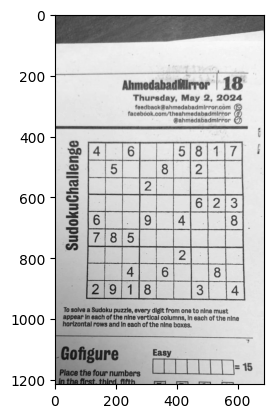

In [177]:
# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')


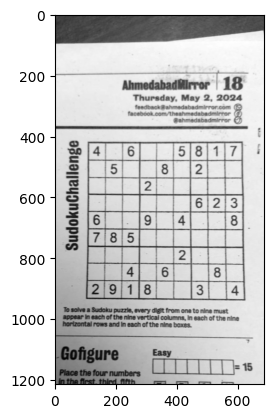

In [178]:
# Apply Gaussian Blur to the image
x, y = max(img.shape[0]//200, 3), max(img.shape[1]//200, 3)
blurred = cv2.GaussianBlur(gray, (x+(x+1)%2, y+(y+1)%2), 0)
plt.imshow(blurred, cmap='gray')


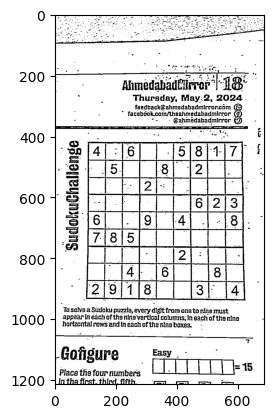

In [179]:
# Apply Adaptive Thresholding to the image
thresholded_img = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)
plt.imshow(thresholded_img, cmap='gray')


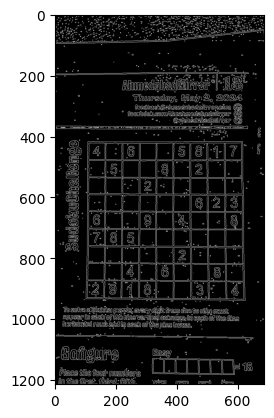

In [180]:
# Canny Edge Detection
edges = cv2.Canny(thresholded_img, 50, 150)
plt.imshow(edges, cmap='gray')

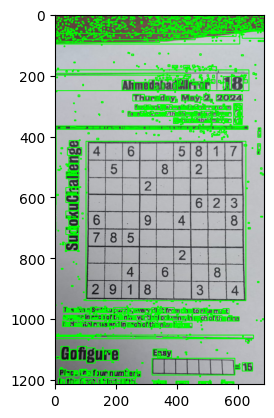

In [181]:
# Find the main contour
contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Plot the contours
contour_img = img.copy()
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contour_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(contour_img)


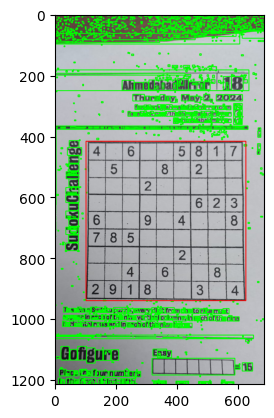

In [182]:
# Plot the main contour
main_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(main_contour)
cv2.rectangle(contour_img, (x, y), (x+w, y+h), (255, 0, 0), 2)
plt.imshow(contour_img)

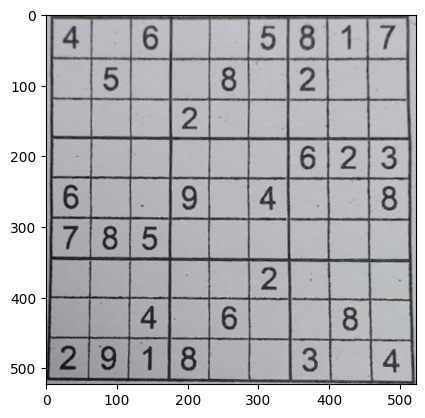

In [187]:
# Crop the main contour
cropped_img = img[y:y+h, x:x+w]
plt.imshow(cropped_img)


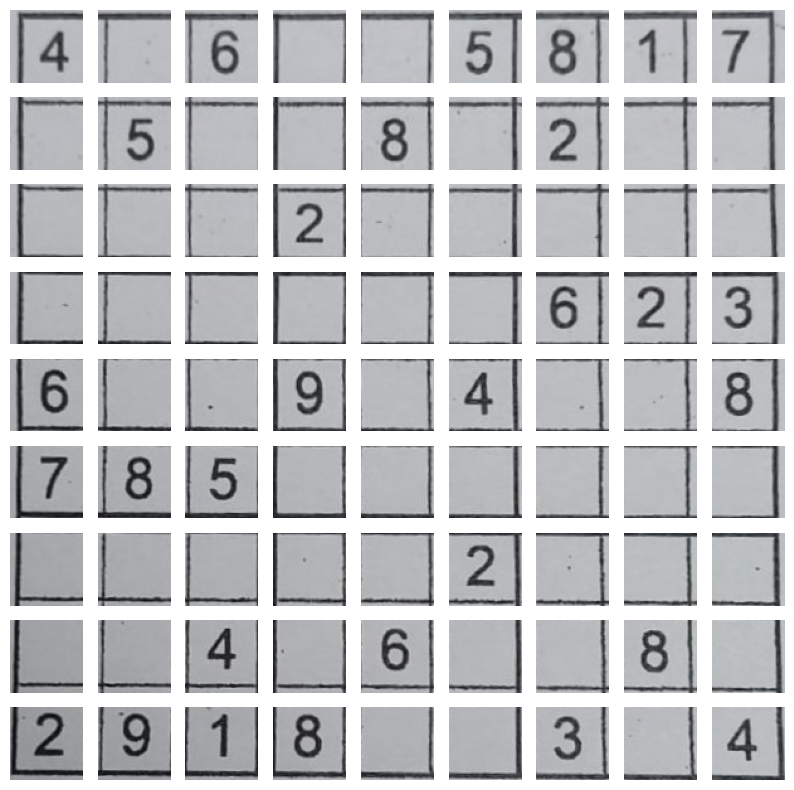

In [188]:
# Divide the cropped image into 81 cells and subplot
cell_height, cell_width = h//9, w//9
fig, axs = plt.subplots(9, 9, figsize=(10, 10))
for i in range(9):
    for j in range(9):
        cell = cropped_img[i*cell_height:(i+1)*cell_height, j*cell_width:(j+1)*cell_width]
        axs[i, j].imshow(cell)
        axs[i, j].axis('off')
plt.show()

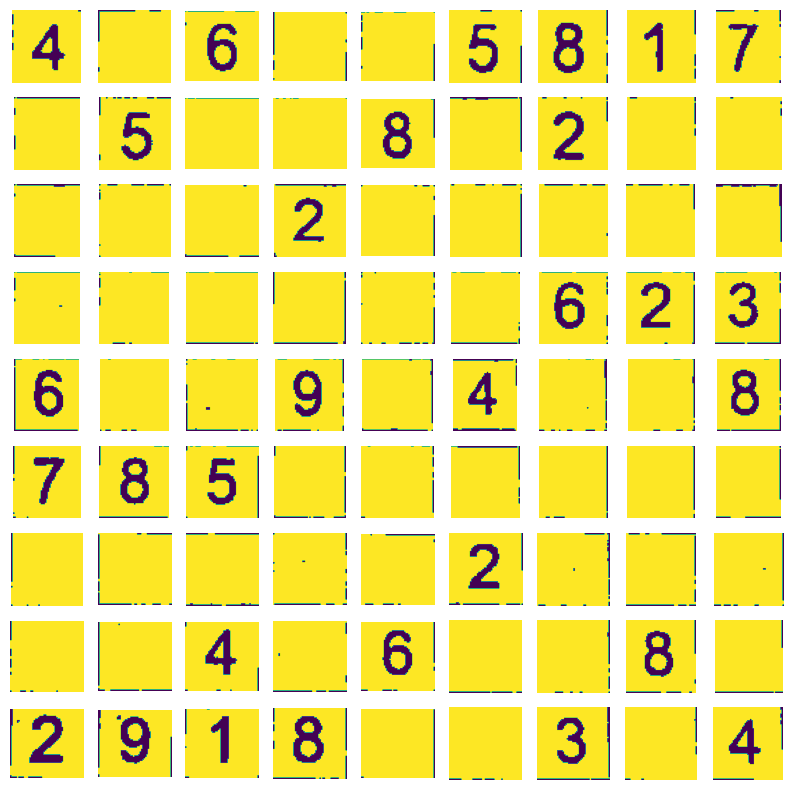

In [189]:
# For every cell, plot the cell with its largets contour
fig, axs = plt.subplots(9, 9, figsize=(10, 10))
digits = []
for i in range(9):
    for j in range(9):
        cell = cropped_img[i*cell_height:(i+1)*cell_height, j*cell_width:(j+1)*cell_width]
        _, thresholded_cell = cv2.threshold(cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY), 128, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresholded_cell, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(contour)
        digit = thresholded_cell[y:y+h, x:x+w]
        digits.append(digit)
        axs[i, j].imshow(digit, cmap='gray')
        axs[i, j].axis('off')
plt.show()

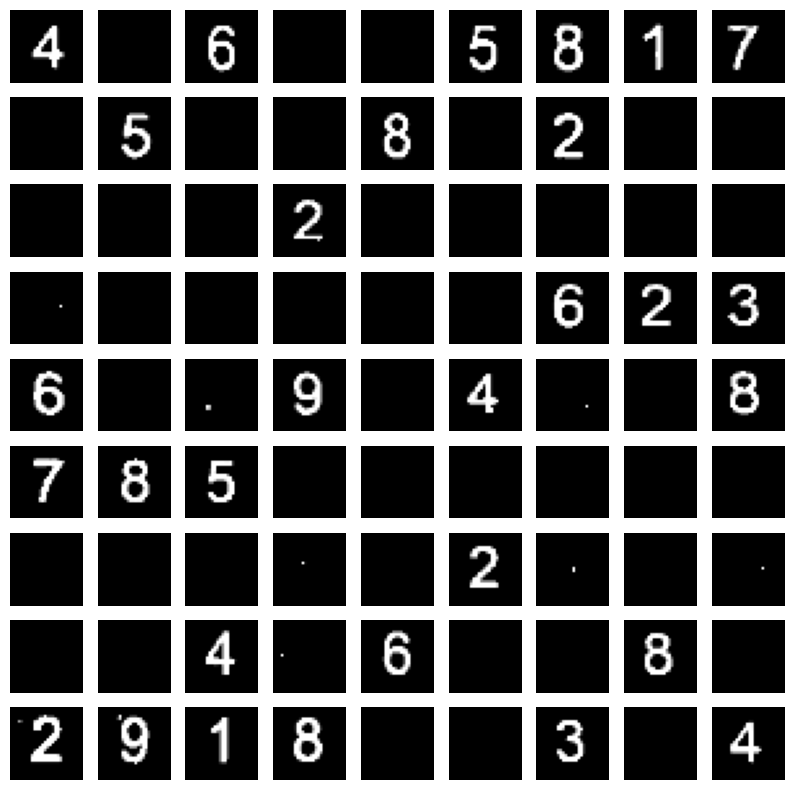

In [206]:
# For every cell, plot the cell with its largets contour, remove border and plot the digit in Grayscale. If no contour is present, keep a white image
# In grayscale
fig, axs = plt.subplots(9, 9, figsize=(10, 10))
digits = []
for i in range(9):
    for j in range(9):
        cell = cropped_img[i*cell_height:(i+1)*cell_height, j*cell_width:(j+1)*cell_width]
        _, thresholded_cell = cv2.threshold(cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY), 128, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresholded_cell, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(contour)
        digit = thresholded_cell[y:y+h, x:x+w]
        # Crop the border
        digit = digit[3:-3, 3:-3]
        # Create a buffer of 5 pixels   
        digit = cv2.copyMakeBorder(digit, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        # Invert the image
        digit = cv2.bitwise_not(digit)
        # Resize the image
        digit = cv2.resize(digit, (28, 28))
        digits.append(digit)

        axs[i, j].imshow(digit, cmap='gray')
        axs[i, j].axis('off')

plt.show()

In [207]:
# Function to predict the digit
def predict_digit(digit_img):
    """
    This function predicts the digit in the image.
    The steps involved are:
    1. Resize the image.
    2. Predict the digit.
    
    Parameters:
    digit_img:
        np.ndarray
        The digit image.
        
    Returns:
        int
        The predicted digit.
        """
    img = cv2.resize(digit_img, (28, 28))
    img = np.array(img).reshape(-1, 28, 28, 1)
    predictions = model.predict(img)
    return np.argmax(predictions)

# Function to predict the sudoku
def predict_sudoku(digits: list):
  """
  This function predicts the sudoku from the digits.
  The steps involved are:
  1. From all the digits, predict the digit and append it to the sudoku array.
  
  Parameters:
  digits:
      list
      The digits in the image.
        
    Returns:
        list
        The predicted sudoku."""
  sudoku = []
  for digit in digits:
    if np.sum(digit) > 255*30:
      sudoku.append(predict_digit(digit))
    else:
      sudoku.append(0)
  return sudoku


In [209]:
digits = np.array(digits)
digits.shape


(81, 28, 28)

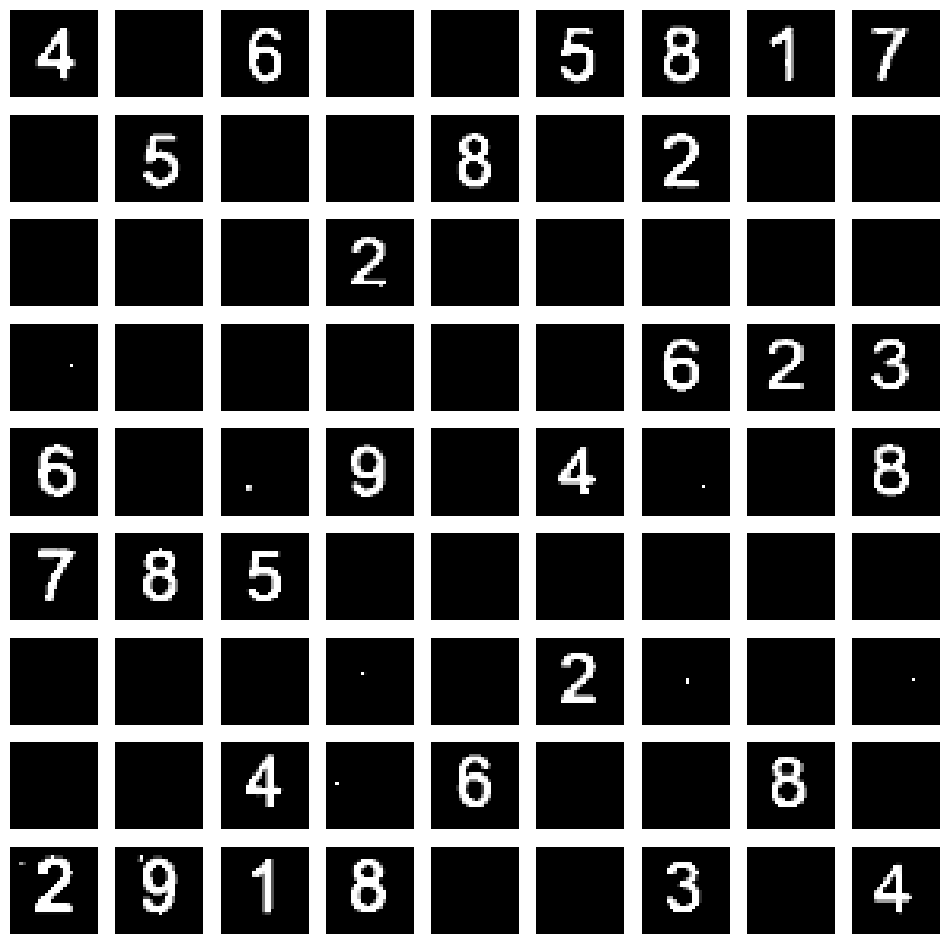

In [210]:
digits = np.array(digits)
fig, ax = plt.subplots(9, 9, figsize=(12, 12))
for i in range(9):
    for j in range(9):
        ax[i, j].imshow(digits[i*9+j], cmap='gray')
        ax[i, j].axis('off')
plt.show()

In [211]:
# Predict the sudoku
sudoku = predict_sudoku(digits)
sudoku = np.array(sudoku).reshape(9,9)
sudoku = np.transpose(sudoku)
sudoku = sudoku.tolist()
print(sudoku)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

[4, 0, 6, 0, 0, 5, 8, 1, 7]
[0, 5, 0, 0, 8, 0, 2, 0, 0]
[0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 6, 2, 3]
[6, 0, 0, 9, 0, 4, 0, 0, 8]
[7, 8, 5, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 2, 0, 0, 0]
[0, 0, 4, 0, 6, 0, 0, 8, 0]
[2, 9, 1, 8, 0, 0, 3, 0, 4]


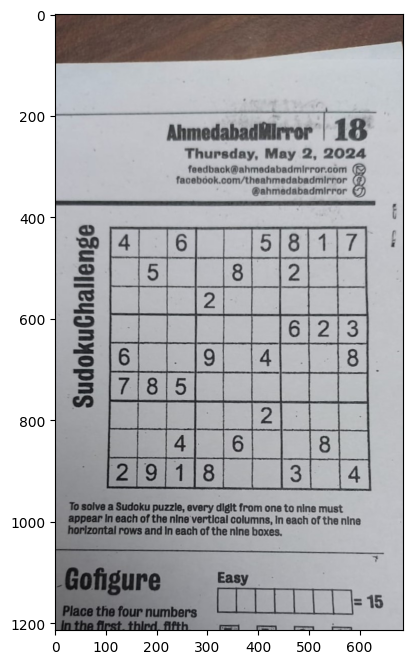

In [219]:
# Plot the original image with the sudoku
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img)

# Print the transpose of the sudoku
sudoku = np.array(sudoku).reshape(9,9)
sudoku = np.transpose(sudoku)
sudoku_list = sudoku.tolist()
for row in sudoku_list:
    print(row)

# Trial of Img2Arr

In [223]:
import Img2Arr

# Convert the image to an array
image = cv2.imread(img_path)
sudoku = Img2Arr.img2arr(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [224]:
print(sudoku)

[[4, 0, 0, 0, 6, 7, 0, 0, 2], [0, 5, 0, 0, 0, 8, 0, 0, 9], [6, 0, 0, 0, 0, 5, 0, 4, 1], [0, 0, 2, 0, 9, 0, 0, 0, 8], [0, 8, 0, 0, 0, 0, 0, 6, 0], [5, 0, 0, 0, 4, 0, 2, 0, 0], [8, 2, 0, 6, 0, 0, 0, 0, 3], [1, 0, 0, 2, 0, 0, 0, 8, 0], [7, 0, 0, 3, 8, 0, 0, 0, 4]]
